In [23]:
import pandas as pd
import os
import math
import numpy as np
import matplotlib.pyplot as plt

In [64]:
noise = pd.read_csv('data_noisy_gain20', header=None, skip_blank_lines=False)
noise[0] = noise[0].str.replace("(", "")
noise[1] = noise[1].str.replace(")", "")

noise = noise.astype(float)
noise[2] = noise[0]**2 + noise[1]**2 #power level of the 
noise[2] = 10*np.log10(noise[2]) #RSS

noise = noise.replace([np.inf, -np.inf], np.nan)
noise = noise.dropna(axis = 0, inplace=False)

# noise = noise[noise[2] <= 0]
noise_floor = sum(noise[2]) / len(noise[2])
print(noise_floor)

/home/jos/.local/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


-91.87124006985326


In [60]:
drone = pd.read_csv('data_drone_gain20', header=None, skip_blank_lines=False)
drone[0] = drone[0].str.replace("(", "")
drone[1] = drone[1].str.replace(")", "")

drone = drone.astype(float)
drone[2] = drone[0]**2 + drone[1]**2 #power level of the 
drone[2] = 10*np.log10(drone[2]) #RSS

drone = drone.replace([np.inf, -np.inf], np.nan)
drone = drone.dropna(axis = 0, inplace=False)

drone = drone[drone[2] <= 0]
drone[2] = drone[2].apply(lambda x: max(x, noise_floor))
print(drone)


/home/jos/.local/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


                    0              1            2
0       -1.953180e-03   1.953180e-03   -51.174855
37       3.465300e-80   1.314630e-71 -1378.930012
38       1.805780e-47   2.212970e-52  -934.866703
105      3.465300e-80   1.314630e-71 -1378.930012
106      1.805780e-47   2.212970e-52  -934.866703
...               ...            ...          ...
2151314  1.163570e-72  6.928950e-310 -1378.930012
2151322  3.465300e-80   1.314630e-71 -1378.930012
2151323  1.805780e-47   2.212970e-52  -934.866703
2151366  3.465300e-80   1.314630e-71 -1378.930012
2151367  1.805780e-47   2.212970e-52  -934.866703

[53075 rows x 3 columns]


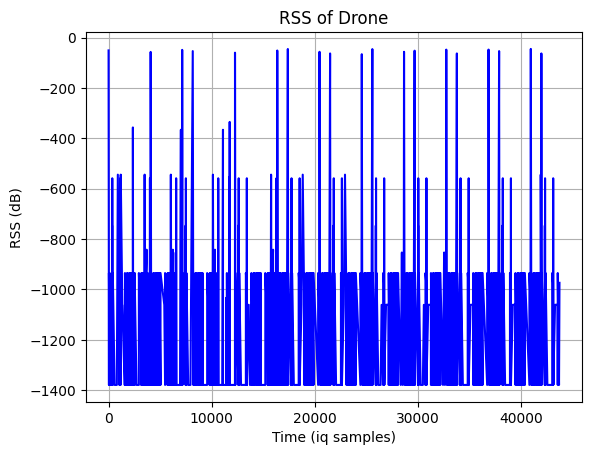

In [61]:
data = drone[2][0: 1000]
data.plot(kind='line', color='blue')
plt.title('RSS of Drone')
plt.xlabel('Time (iq samples)')
plt.ylabel('RSS (dB)')
plt.grid(True)
plt.show()

In [72]:
def split_dataframe(df, column, threshold):
    parts = []
    start_idx = None
    
    for index, row in df.iterrows():
        if start_idx is None:
            if row[column] > threshold:
                start_idx = index
        elif row[column] <= threshold:
            parts.append(df.loc[start_idx:index-1])
            start_idx = None
    
    if start_idx is not None:
        parts.append(df.loc[start_idx:])
    
    return parts

In [82]:
result = split_dataframe(drone, 2, noise_floor)

result[2]

,0,1,2
7136,0.00293,-0.001953,-49.0663
